# Fire Detection

### Importing the Libraries

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import utils
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization,Dense,SeparableConv2D,MaxPooling2D,Activation,Flatten,Dropout

In [ ]:
# define the initial learning rate, batch size, and number of epochs
INIT_LR = 0.1
BATCH_SIZE = 64
NUM_EPOCHS = 5 #50
lr_find = True

classes = ['Non_Fire','Fire']

In [ ]:
images = []
labels = []
for c in classes:
    try:
        for img in os.listdir(r'C:/Users/HOME/Desktop/Fire-and-Smoke-Detector-main/Robbery_Accident_Fire/'+c):
            img = cv2.imread(r'C:/Users/HOME/Desktop/Fire-and-Smoke-Detector-main/Robbery_Accident_Fire/'+c+'/'+img)
            img = cv2.resize(img,(128,128))
            images.append(img)
            labels.append([0,1][c=='Fire'])
    except:
        pass

images = np.array(images,dtype='float32')/255.


In [ ]:
# just visualizing random images from the dataset created above

ind = np.random.randint(0,len(images))
cv2.imshow(str(labels[ind]),images[ind])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
labels = np.array(labels)
labels = utils.to_categorical(labels,num_classes=2)

classTotals = labels.sum(axis=0)
classWeight = classTotals.max() / classTotals

C:\Users\HOME\AppData\Local\Temp\ipykernel_9284\1252032975.py:5: RuntimeWarning: divide by zero encountered in true_divide
  classWeight = classTotals.max() / classTotals


In [ ]:
d = {}
d[0] = classWeight[0]
d[1] = classWeight[1]
d

{0: inf, 1: 1.0}

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.25, shuffle=True, random_state=42)

In [ ]:
aug = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [ ]:
model = Sequential()

# CONV => RELU => POOL
model.add(SeparableConv2D(16,(7,7),padding='same',input_shape=(128,128,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# CONV => RELU => POOL
model.add(SeparableConv2D(32,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# CONV => RELU => CONV => RELU => POOL
model.add(SeparableConv2D(64,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(SeparableConv2D(64,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# first set of FC => RELU layers
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))


# second set of FC => RELU layers
model.add(Dense(128))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# softmax classifier
model.add(Dense(len(classes)))
model.add(Activation("softmax"))

opt = SGD(learning_rate=INIT_LR, momentum=0.9,decay=INIT_LR / NUM_EPOCHS)

model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

print(model.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_4 (Separabl (None, 128, 128, 16)      211       
_________________________________________________________________
activation_7 (Activation)    (None, 128, 128, 16)      0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 128, 128, 16)      64        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
separable_conv2d_5 (Separabl (None, 64, 64, 32)        688       
_________________________________________________________________
activation_8 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 64, 64, 32)       

In [ ]:
print("[INFO] training network...")

H = model.fit(
    aug.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_test, y_test),
    steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
    epochs=NUM_EPOCHS,
    class_weight=d,
    verbose=1)

print("[INFO] serializing network to '{}'...".format('output/model'))
model.save('output/fire_detection.h5')


[INFO] training network...
Epoch 1/5
16/16 [==============================] - 34s 2s/step - loss: 0.3529 - accuracy: 0.8746 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/5
16/16 [==============================] - 34s 2s/step - loss: 0.0043 - accuracy: 0.9990 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/5
16/16 [==============================] - 35s 2s/step - loss: 3.9343e-04 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/5
16/16 [==============================] - 33s 2s/step - loss: 0.0024 - accuracy: 0.9990 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/5
16/16 [==============================] - 34s 2s/step - loss: 2.5339e-04 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
[INFO] serializing network to 'output/model'...


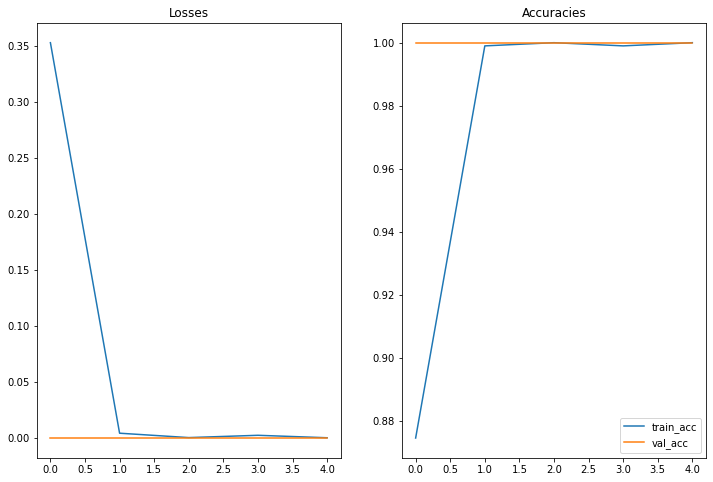

In [ ]:
N = np.arange(0, NUM_EPOCHS)

plt.figure(figsize=(12,8))

plt.subplot(121)
plt.title("Losses")
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")

plt.subplot(122)
plt.title("Accuracies")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")


plt.legend()
plt.savefig("output/training_plot.png")


In [ ]:
# load the trained model from disk
print("[INFO] loading model...")
model = load_model('output/fire_detection.h5')


[INFO] loading model...


In [ ]:
for i in range(50):
    random_index = np.random.randint(0,len(X_test))
    org_img = X_test[random_index]*255
    img = org_img.copy()
    img = cv2.resize(img,(128,128))
    img = img.astype('float32')/256
    pred = model.predict(np.expand_dims(img,axis=0))[0]
    result = classes[np.argmax(pred)]
    org_img = cv2.resize(org_img,(500,500))
    cv2.putText(org_img, result, (35, 50), cv2.FONT_HERSHEY_SIMPLEX,1.25, (0, 255, 0), 3)
    cv2.imwrite('output/testing/{}.png'.format(i),org_img)
